# Eatery recommender framework in Bangalore
## Introduction

### This notebook is the Capstone project towards **IBM DATA SCIENCE PROFESSIONAL** course on Coursera.
### By Raunak Kumar Singh

# Importing all the required libraries.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import folium 
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

# Reading from the prepared dataset and displaying the head records and removing Unnamed: 0 records

In [3]:
df = pd.read_csv('complete_dataset.csv')

In [4]:
df.head(10)

,Unnamed: 0,Borough,Neighborhoods,Latitude,Longitude,Population,City,AverageIncome
0,0,Central,Cantonment area,12.972442,77.580643,866377,Bangalore,18944.099792
1,1,Central,Domlur,12.960992,77.638726,743186,Bangalore,56837.022198
2,2,Central,Indiranagar,12.971891,77.641151,474289,Bangalore,41991.817435
3,3,Central,Jeevanbheemanagar,12.962900,77.659500,527874,Bangalore,6667.447632
4,4,Central,Malleswaram,13.003100,77.564300,893629,Bangalore,53270.063892
5,5,Central,Pete area,12.962700,77.575800,730999,Bangalore,50712.430215
6,6,Central,Rajajinagar,12.990100,77.552500,981362,Bangalore,60967.535874
7,7,Central,Sadashivanagar,13.006800,77.581300,662625,Bangalore,59943.541564
8,8,Central,Seshadripuram,12.993500,77.578700,396862,Bangalore,58407.090338
9,9,Central,Shivajinagar,12.985700,77.605700,77836,Bangalore,55850.962099


In [5]:
df.drop('Unnamed: 0',axis=1,inplace=True)

# Creating 'Population' and 'Income' dataframe from the main dataframe

In [6]:
bangalore_population = pd.DataFrame(df[['Borough','Neighborhoods','Population']])

In [7]:
bangalore_population.head()

,Borough,Neighborhoods,Population
0,Central,Cantonment area,866377
1,Central,Domlur,743186
2,Central,Indiranagar,474289
3,Central,Jeevanbheemanagar,527874
4,Central,Malleswaram,893629


In [8]:
bangalore_population.to_csv('population_dataset.csv')

In [9]:
bangalore_income = pd.DataFrame(df[['Borough','Neighborhoods','AverageIncome']])

In [10]:
bangalore_income.head()

,Borough,Neighborhoods,AverageIncome
0,Central,Cantonment area,18944.099792
1,Central,Domlur,56837.022198
2,Central,Indiranagar,41991.817435
3,Central,Jeevanbheemanagar,6667.447632
4,Central,Malleswaram,53270.063892


In [11]:
bangalore_income.to_csv('income_dataset.csv')

# Getting Latitude and Longitude of Bangalore

In [12]:
bangalore_latitude = df['Latitude'].mean()
bangalore_longitude = df['Longitude'].mean()
print("Latitude and Longitude of Bangalore are : ",bangalore_latitude,bangalore_longitude)

Latitude and Longitude of Bangalore are :  12.9623396203125 77.601752946875


# Keying the credentials to be used in Foursquare API

In [13]:
CLIENT_ID = 'DR5WZL2VKZE30CYOGB5YTLJQ2PPP32BCSZXGMOIW0SER4KJM'
CLIENT_SECRET = 'O5NMTGE2OHR0Y4I0WNKSFSLBR0KFJP4QVUZRSLA34G4YRFW2'
VERSION = '20210527'
LIMIT = 100

# Data Frame and other data for Drawing bangalore map 

In [14]:
unique_boroughs_of_bangalore = df['Borough'].unique().tolist()

In [15]:
unique_boroughs_of_bangalore

['Central',
 'Eastern',
 'NorthEastern',
 'Northern',
 'SouthEastern',
 'Southern',
 'SouthernSuburbs',
 'Western']

In [16]:
borough_colors ={}
for i in unique_boroughs_of_bangalore:
    borough_colors[i] = '#%02X%02X%02X' % tuple(np.random.choice(range(256),size=3))

In [17]:
borough_colors

{'Central': '#3A8A51',
 'Eastern': '#9D1940',
 'NorthEastern': '#1EC5F6',
 'Northern': '#518051',
 'SouthEastern': '#4B2206',
 'Southern': '#DD7196',
 'SouthernSuburbs': '#40599C',
 'Western': '#4BA12B'}

In [18]:
bangalore_map = folium.Map(location=[bangalore_latitude,bangalore_longitude],zoom_start=12,control_scale=True)

In [19]:
for lat,lng,boro,nei in zip(df['Latitude'],
                           df['Longitude'],
                           df['Borough'],
                           df['Neighborhoods']):
    label_text = boro + ' - ' + nei
    label = folium.Popup(label_text,parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    tooltip = label_text,
    radius = 4,
    popup = label,
    color=borough_colors[boro],
    fill=True,
    fill_color = borough_colors[boro],
    fill_opacity=0.7).add_to(bangalore_map)

In [20]:
bangalore_map

# Exploring bangalore Neighborhoods using FourSquare API

In [21]:
def getNearbyVenues(names, boro, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, boro, lat, lng in zip(names, boro, latitudes, longitudes):
        print("Fetching venues for : ",name)            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            boro,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Borough',
                             'Neighborhood Latitude', 
                             'Neighborhood Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

In [22]:
bangalore_venues = getNearbyVenues(names=df['Neighborhoods'],latitudes=df['Latitude'],longitudes=df['Longitude'],boro=df['Borough'])

Fetching venues for :  Cantonment area
Fetching venues for :  Domlur
Fetching venues for :  Indiranagar
Fetching venues for :  Jeevanbheemanagar
Fetching venues for :  Malleswaram
Fetching venues for :  Pete area
Fetching venues for :  Rajajinagar
Fetching venues for :  Sadashivanagar
Fetching venues for :  Seshadripuram
Fetching venues for :  Shivajinagar
Fetching venues for :  Ulsoor
Fetching venues for :  Vasanth Nagar
Fetching venues for :  Bellandur
Fetching venues for :  CV Raman Nagar
Fetching venues for :  Hoodi
Fetching venues for :  Krishnarajapuram
Fetching venues for :  Mahadevapura
Fetching venues for :  Marathahalli
Fetching venues for :  Varthur
Fetching venues for :  Whitefield
Fetching venues for :  Banaswadi
Fetching venues for :  HBR Layout
Fetching venues for :  Horamavu
Fetching venues for :  Kammanahalli
Fetching venues for :  Lingarajapuram
Fetching venues for :  Ramamurthy Nagar
Fetching venues for :  Hebbal
Fetching venues for :  Jalahalli
Fetching venues for :

In [28]:
print("Total number of venues found in Bangalore are : ",bangalore_venues.shape[0])

Total number of venues found in Bangalore are :  587


In [29]:
bangalore_venues.head(5)

,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Cantonment area,Central,12.972442,77.580643,Hotel Fishland,12.975569,77.578592,Seafood Restaurant
1,Cantonment area,Central,12.972442,77.580643,Vasudev Adigas,12.973707,77.579257,Indian Restaurant
2,Cantonment area,Central,12.972442,77.580643,Adigas Hotel,12.973554,77.579161,Restaurant
3,Cantonment area,Central,12.972442,77.580643,Sapna Book House,12.976355,77.578461,Bookstore
4,Cantonment area,Central,12.972442,77.580643,Kamat Yatrinivas,12.975985,77.578125,Indian Restaurant


In [23]:
bangalore_venues.groupby('Venue Category').count()['Neighborhood'].sort_values(ascending=False).head(10)

Venue Category
Indian Restaurant       116
Café                     30
Fast Food Restaurant     26
Bakery                   24
Ice Cream Shop           21
Department Store         19
Pizza Place              18
Coffee Shop              15
Chinese Restaurant       13
Hotel                    12
Name: Neighborhood, dtype: int64

In [24]:
print("Total number of unique categories in bangalore are : ",len(bangalore_venues['Venue Category'].unique()))

Total number of unique categories in bangalore are :  128


# Getting number of venues per neighborhood

In [25]:
individual_bangalore_venue_count = bangalore_venues.groupby(['Borough','Neighborhood'])['Borough'].count().to_frame()

In [26]:
individual_bangalore_venue_count

Borough
Borough Neighborhood                 
Central Cantonment area             5
        Domlur                      9
        Indiranagar                58
        Jeevanbheemanagar           4
        Malleswaram                 7
...                               ...
Western Nagarbhavi                  9
        Nandini Layout              1
        Nayandahalli                3
        Rajarajeshwari Nagar        7
        Vijayanagar                 4

[62 rows x 1 columns]

In [27]:
individual_bangalore_venue_count.rename(columns={'Borough':'NumberOfVenues'},inplace=True)

In [28]:
individual_bangalore_venue_count.reset_index(inplace=True)

In [29]:
individual_bangalore_venue_count

,Borough,Neighborhood,NumberOfVenues
0,Central,Cantonment area,5
1,Central,Domlur,9
2,Central,Indiranagar,58
3,Central,Jeevanbheemanagar,4
4,Central,Malleswaram,7
...,...,...,...
57,Western,Nagarbhavi,9
58,Western,Nandini Layout,1
59,Western,Nayandahalli,3
60,Western,Rajarajeshwari Nagar,7


[Text(0, 0, 'Cantonment area'),
 Text(1, 0, 'Domlur'),
 Text(2, 0, 'Indiranagar'),
 Text(3, 0, 'Jeevanbheemanagar'),
 Text(4, 0, 'Malleswaram'),
 Text(5, 0, 'Pete area'),
 Text(6, 0, 'Rajajinagar'),
 Text(7, 0, 'Sadashivanagar'),
 Text(8, 0, 'Seshadripuram'),
 Text(9, 0, 'Shivajinagar'),
 Text(10, 0, 'Ulsoor'),
 Text(11, 0, 'Vasanth Nagar'),
 Text(12, 0, 'Bellandur'),
 Text(13, 0, 'CV Raman Nagar'),
 Text(14, 0, 'Hoodi'),
 Text(15, 0, 'Krishnarajapuram'),
 Text(16, 0, 'Mahadevapura'),
 Text(17, 0, 'Marathahalli'),
 Text(18, 0, 'Varthur'),
 Text(19, 0, 'Whitefield'),
 Text(20, 0, 'Banaswadi'),
 Text(21, 0, 'HBR Layout'),
 Text(22, 0, 'Horamavu'),
 Text(23, 0, 'Kammanahalli'),
 Text(24, 0, 'Lingarajapuram'),
 Text(25, 0, 'Ramamurthy Nagar'),
 Text(26, 0, 'Hebbal'),
 Text(27, 0, 'Jalahalli'),
 Text(28, 0, 'Mathikere'),
 Text(29, 0, 'R. T. Nagar'),
 Text(30, 0, 'Vidyaranyapura'),
 Text(31, 0, 'Yelahanka'),
 Text(32, 0, 'Yeshwanthpur'),
 Text(33, 0, 'BTM Layout'),
 Text(34, 0, 'Bommanahalli

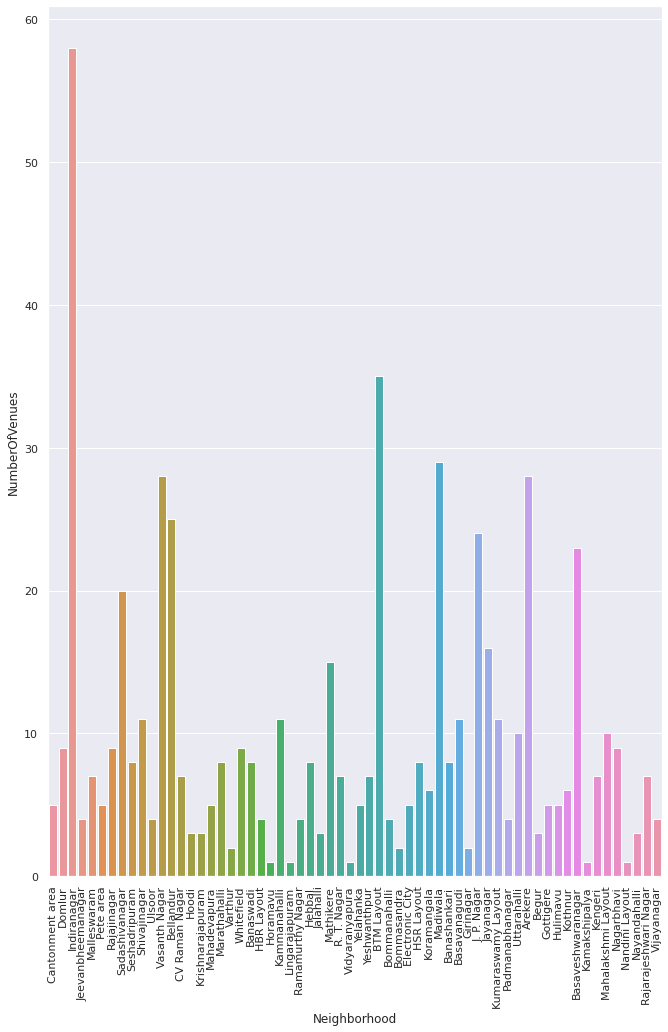

In [30]:
sns.set(rc={'figure.figsize':(11,16)})
plot = sns.barplot(x='Neighborhood',y='NumberOfVenues',data=individual_bangalore_venue_count)
plot.set_xticklabels(individual_bangalore_venue_count['Neighborhood'],rotation=90)

# From the above graph we can see that Domlur has most number of venues and soo on...

## Investigating Whitefield settings in Bangalore

In [31]:
bangalore_venues[bangalore_venues['Neighborhood']=='Whitefield']

,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
221,Whitefield,Eastern,12.9698,77.7499,Herbs and Spices,12.968145,77.750862,Eastern European Restaurant
222,Whitefield,Eastern,12.9698,77.7499,Golds Gym,12.972217,77.750529,Gym / Fitness Center
223,Whitefield,Eastern,12.9698,77.7499,Chef Baker's,12.969730,77.751302,Bakery
224,Whitefield,Eastern,12.9698,77.7499,Royal Orchid Suites,12.966774,77.751262,Hotel
225,Whitefield,Eastern,12.9698,77.7499,The river side bar and kitchen,12.967298,77.749614,Hotel Bar
226,Whitefield,Eastern,12.9698,77.7499,Reliance Fresh,12.970894,77.750045,Department Store
227,Whitefield,Eastern,12.9698,77.7499,Cheenavala,12.966435,77.749368,Kerala Restaurant
228,Whitefield,Eastern,12.9698,77.7499,refresh,12.965621,77.749234,Café
229,Whitefield,Eastern,12.9698,77.7499,Onions,12.965671,77.748877,Indian Restaurant


# One hot encoding for letting us to compare different venues based on some common scale


In [32]:
bangalore_venues_onehot = pd.get_dummies(bangalore_venues[['Venue Category']])

In [33]:
bangalore_venues_onehot

,Venue Category_ATM,Venue Category_Andhra Restaurant,Venue Category_Art Museum,Venue Category_Arts & Crafts Store,Venue Category_Asian Restaurant,Venue Category_Athletics & Sports,Venue Category_Auto Garage,Venue Category_BBQ Joint,Venue Category_Badminton Court,Venue Category_Bakery,...,Venue Category_Tea Room,Venue Category_Tex-Mex Restaurant,Venue Category_Toll Plaza,Venue Category_Train Station,Venue Category_Travel & Transport,Venue Category_Udupi Restaurant,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Women's Store,Venue Category_Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
588,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
589,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
590,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
bangalore_venues_onehot['Neighborhood'] = bangalore_venues['Neighborhood']
bangalore_venues_grouped = bangalore_venues_onehot.groupby('Neighborhood').mean().reset_index()
bangalore_venues_grouped

,Neighborhood,Venue Category_ATM,Venue Category_Andhra Restaurant,Venue Category_Art Museum,Venue Category_Arts & Crafts Store,Venue Category_Asian Restaurant,Venue Category_Athletics & Sports,Venue Category_Auto Garage,Venue Category_BBQ Joint,Venue Category_Badminton Court,...,Venue Category_Tea Room,Venue Category_Tex-Mex Restaurant,Venue Category_Toll Plaza,Venue Category_Train Station,Venue Category_Travel & Transport,Venue Category_Udupi Restaurant,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Women's Store,Venue Category_Yoga Studio
0,Arekere,0.0,0.0,0.0,0.0,0.0,0.035714,0.0,0.0,0.035714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,BTM Layout,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.057143,0.0,0.0,0.0
2,Banashankari,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,Banaswadi,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.0
4,Basavanagudi,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,Vidyaranyapura,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
58,Vijayanagar,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
59,Whitefield,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
60,Yelahanka,0.4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.2,0.0,0.0,0.000000,0.0,0.0,0.0


In [35]:
number_of_top_venues = 5

In [36]:
for hood in bangalore_venues_grouped['Neighborhood']:
    print('---------',hood,'---------')
    temp = bangalore_venues_grouped[bangalore_venues_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['Venue','Frequency']
    temp = temp.iloc[1:]
    temp['Frequency'] = temp['Frequency'].astype(float)
    temp = temp.round({'Frequency': 2})
    print(temp.sort_values('Frequency', ascending=False).reset_index(drop=True).head(number_of_top_venues))
    print('\n')

--------- Arekere ---------
                                Venue  Frequency
0    Venue Category_Indian Restaurant       0.21
1  Venue Category_Sporting Goods Shop       0.14
2          Venue Category_Pizza Place       0.07
3       Venue Category_Breakfast Spot       0.04
4     Venue Category_Department Store       0.04


--------- BTM Layout ---------
                                          Venue  Frequency
0              Venue Category_Indian Restaurant       0.20
1                    Venue Category_Snack Place       0.09
2                 Venue Category_Ice Cream Shop       0.09
3  Venue Category_Vegetarian / Vegan Restaurant       0.06
4                    Venue Category_Pizza Place       0.06


--------- Banashankari ---------
                                    Venue  Frequency
0           Venue Category_Clothing Store       0.25
1                     Venue Category_Café       0.25
2  Venue Category_North Indian Restaurant       0.12
3           Venue Category_Breakfast Spot   

Frequency of each neighborhood and its top 5 venues can be known. This is very important is we can analyze top neighborhoods with most busy restaurants

In [37]:
def return_most_common_venues(row, number_of_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:number_of_top_venues]

In [38]:
number_of_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(number_of_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bangalore_venues_grouped['Neighborhood']

for ind in np.arange(bangalore_venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bangalore_venues_grouped.iloc[ind, :], number_of_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arekere,Venue Category_Indian Restaurant,Venue Category_Sporting Goods Shop,Venue Category_Pizza Place,Venue Category_Gym / Fitness Center,Venue Category_Mughlai Restaurant,Venue Category_Department Store,Venue Category_Chinese Restaurant,Venue Category_Liquor Store,Venue Category_Fast Food Restaurant,Venue Category_Bus Line
1,BTM Layout,Venue Category_Indian Restaurant,Venue Category_Snack Place,Venue Category_Ice Cream Shop,Venue Category_Fast Food Restaurant,Venue Category_Coffee Shop,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Chinese Restaurant,Venue Category_Pizza Place,Venue Category_Bakery,Venue Category_Sandwich Place
2,Banashankari,Venue Category_Clothing Store,Venue Category_Café,Venue Category_North Indian Restaurant,Venue Category_Breakfast Spot,Venue Category_Pizza Place,Venue Category_Indian Restaurant,Venue Category_Yoga Studio,Venue Category_Diner,Venue Category_Electronics Store,Venue Category_Eastern European Restaurant
3,Banaswadi,Venue Category_Indian Restaurant,Venue Category_Convenience Store,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Pharmacy,Venue Category_Café,Venue Category_Bakery,Venue Category_Yoga Studio,Venue Category_Dim Sum Restaurant,Venue Category_Electronics Store,Venue Category_Eastern European Restaurant
4,Basavanagudi,Venue Category_Indian Restaurant,Venue Category_Café,Venue Category_Convenience Store,Venue Category_Metro Station,Venue Category_Restaurant,Venue Category_Mediterranean Restaurant,Venue Category_Hookah Bar,Venue Category_Department Store,Venue Category_Deli / Bodega,Venue Category_Dessert Shop


In [39]:
neighborhoods_venues_sorted.shape

(62, 11)

## Next challenge is to find the optimal k value for clustering and we do it using the elbow method

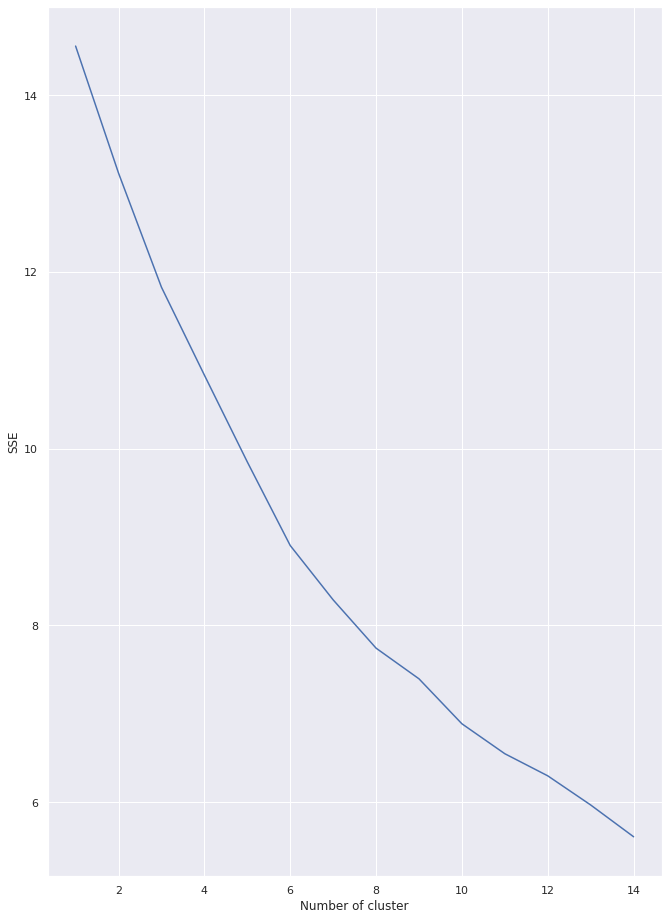

In [40]:
sse = {}
for k in range(1,15):
    kmeans = KMeans(n_clusters=k,random_state=0)
    kmeans.fit(bangalore_venues_grouped.drop('Neighborhood',axis=1))
    bangalore_venues_grouped['Cluster'] = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

### From the above graph, we can see the optimal value for cluster is 5.

In [41]:
kmeans = KMeans(n_clusters=5,random_state=0)

In [42]:
kmeans.fit(bangalore_venues_grouped.drop('Neighborhood',axis=1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [43]:
bangalore_venues_grouped['Cluster'] = kmeans.labels_

In [44]:
bangalore_venues_grouped.groupby('Cluster')['Neighborhood'].count()

Cluster
0    19
1    29
2     5
3     4
4     5
Name: Neighborhood, dtype: int64

In [45]:
bangalore_venues_grouped.columns

Index(['Neighborhood', 'Venue Category_ATM',
       'Venue Category_Andhra Restaurant', 'Venue Category_Art Museum',
       'Venue Category_Arts & Crafts Store', 'Venue Category_Asian Restaurant',
       'Venue Category_Athletics & Sports', 'Venue Category_Auto Garage',
       'Venue Category_BBQ Joint', 'Venue Category_Badminton Court',
       ...
       'Venue Category_Tex-Mex Restaurant', 'Venue Category_Toll Plaza',
       'Venue Category_Train Station', 'Venue Category_Travel & Transport',
       'Venue Category_Udupi Restaurant',
       'Venue Category_Vegetarian / Vegan Restaurant',
       'Venue Category_Vietnamese Restaurant', 'Venue Category_Women's Store',
       'Venue Category_Yoga Studio', 'Cluster'],
      dtype='object', length=130)

In [46]:
neighborhoods_venues_sorted = neighborhoods_venues_sorted.merge(bangalore_venues_grouped,on='Neighborhood')

In [47]:
neighborhoods_venues_sorted.head(4)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,Venue Category_Tex-Mex Restaurant,Venue Category_Toll Plaza,Venue Category_Train Station,Venue Category_Travel & Transport,Venue Category_Udupi Restaurant,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Women's Store,Venue Category_Yoga Studio,Cluster
0,Arekere,Venue Category_Indian Restaurant,Venue Category_Sporting Goods Shop,Venue Category_Pizza Place,Venue Category_Gym / Fitness Center,Venue Category_Mughlai Restaurant,Venue Category_Department Store,Venue Category_Chinese Restaurant,Venue Category_Liquor Store,Venue Category_Fast Food Restaurant,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1
1,BTM Layout,Venue Category_Indian Restaurant,Venue Category_Snack Place,Venue Category_Ice Cream Shop,Venue Category_Fast Food Restaurant,Venue Category_Coffee Shop,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Chinese Restaurant,Venue Category_Pizza Place,Venue Category_Bakery,...,0.0,0.0,0.0,0.0,0.0,0.057143,0.0,0.0,0.0,1
2,Banashankari,Venue Category_Clothing Store,Venue Category_Café,Venue Category_North Indian Restaurant,Venue Category_Breakfast Spot,Venue Category_Pizza Place,Venue Category_Indian Restaurant,Venue Category_Yoga Studio,Venue Category_Diner,Venue Category_Electronics Store,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1
3,Banaswadi,Venue Category_Indian Restaurant,Venue Category_Convenience Store,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Pharmacy,Venue Category_Café,Venue Category_Bakery,Venue Category_Yoga Studio,Venue Category_Dim Sum Restaurant,Venue Category_Electronics Store,...,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,1


In [48]:
neighborhoods_venues_sorted.columns
neighborhoods_venues_sorted = neighborhoods_venues_sorted.merge(bangalore_venues,on='Neighborhood')

In [49]:
# create map
map_clusters = folium.Map(location=[bangalore_latitude, bangalore_longitude], zoom_start=11)

In [50]:
# set color scheme for the clusters
x = np.arange(6)
ys = [i + x + (i*x)**2 for i in range(6)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighborhoods_venues_sorted['Neighborhood Latitude'], neighborhoods_venues_sorted['Neighborhood Longitude'], neighborhoods_venues_sorted['Neighborhood'], neighborhoods_venues_sorted['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       

In [51]:
map_clusters

## Finding similar locations based on user input (recommending location)
#### We need to analyze factors such as population and Income to recommend.

In [52]:
bangalore_income.head()

,Borough,Neighborhoods,AverageIncome
0,Central,Cantonment area,18944.099792
1,Central,Domlur,56837.022198
2,Central,Indiranagar,41991.817435
3,Central,Jeevanbheemanagar,6667.447632
4,Central,Malleswaram,53270.063892


In [53]:
bangalore_population.head()

,Borough,Neighborhoods,Population
0,Central,Cantonment area,866377
1,Central,Domlur,743186
2,Central,Indiranagar,474289
3,Central,Jeevanbheemanagar,527874
4,Central,Malleswaram,893629


In [54]:
bangalore_population['Normalized_population'] = bangalore_population['Population']/bangalore_population['Population'].max(axis=0)
bangalore_population.head()

,Borough,Neighborhoods,Population,Normalized_population
0,Central,Cantonment area,866377,0.880810
1,Central,Domlur,743186,0.755567
2,Central,Indiranagar,474289,0.482190
3,Central,Jeevanbheemanagar,527874,0.536668
4,Central,Malleswaram,893629,0.908516


In [55]:
bangalore_income['Normalized_income'] = bangalore_income['AverageIncome']/bangalore_income['AverageIncome'].max(axis=0)
bangalore_income.head()

,Borough,Neighborhoods,AverageIncome,Normalized_income
0,Central,Cantonment area,18944.099792,0.293051
1,Central,Domlur,56837.022198,0.879225
2,Central,Indiranagar,41991.817435,0.649581
3,Central,Jeevanbheemanagar,6667.447632,0.103140
4,Central,Malleswaram,53270.063892,0.824047


In [56]:
bangalore_venues_grouped.head(1)

,Neighborhood,Venue Category_ATM,Venue Category_Andhra Restaurant,Venue Category_Art Museum,Venue Category_Arts & Crafts Store,Venue Category_Asian Restaurant,Venue Category_Athletics & Sports,Venue Category_Auto Garage,Venue Category_BBQ Joint,Venue Category_Badminton Court,...,Venue Category_Tex-Mex Restaurant,Venue Category_Toll Plaza,Venue Category_Train Station,Venue Category_Travel & Transport,Venue Category_Udupi Restaurant,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Women's Store,Venue Category_Yoga Studio,Cluster
0,Arekere,0.0,0.0,0.0,0.0,0.0,0.035714,0.0,0.0,0.035714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


#### recommending Veg restaurants

In [57]:
bangalore_veg = bangalore_venues_onehot.groupby(['Neighborhood']).sum().reset_index()
bangalore_veg.head()

,Neighborhood,Venue Category_ATM,Venue Category_Andhra Restaurant,Venue Category_Art Museum,Venue Category_Arts & Crafts Store,Venue Category_Asian Restaurant,Venue Category_Athletics & Sports,Venue Category_Auto Garage,Venue Category_BBQ Joint,Venue Category_Badminton Court,...,Venue Category_Tea Room,Venue Category_Tex-Mex Restaurant,Venue Category_Toll Plaza,Venue Category_Train Station,Venue Category_Travel & Transport,Venue Category_Udupi Restaurant,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Women's Store,Venue Category_Yoga Studio
0,Arekere,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,BTM Layout,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
2,Banashankari,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Banaswadi,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,Basavanagudi,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
bangalore_veg['Venue Category_Vegetarian / Vegan Restaurant']

0     0
1     2
2     0
3     1
4     0
     ..
57    0
58    0
59    0
60    0
61    0
Name: Venue Category_Vegetarian / Vegan Restaurant, Length: 62, dtype: uint8

In [59]:
bangalore_veg = bangalore_veg[['Neighborhood','Venue Category_Vegetarian / Vegan Restaurant']]

In [60]:
bangalore_veg.rename(columns={'Venue Category_Vegetarian / Vegan Restaurant':'NumberOfVegRestaurants'},inplace=True)

In [61]:
bangalore_veg.head()

,Neighborhood,NumberOfVegRestaurants
0,Arekere,0
1,BTM Layout,2
2,Banashankari,0
3,Banaswadi,1
4,Basavanagudi,0


In [62]:
bangalore_veg['NumberOfNonVeganrestaurants'] = 1-(bangalore_veg['NumberOfVegRestaurants']/bangalore_veg['NumberOfVegRestaurants'].max(axis=0))

In [63]:
bangalore_veg.head(10)

,Neighborhood,NumberOfVegRestaurants,NumberOfNonVeganrestaurants
0,Arekere,0,1.0
1,BTM Layout,2,0.0
2,Banashankari,0,1.0
3,Banaswadi,1,0.5
4,Basavanagudi,0,1.0
5,Basaveshwaranagar,0,1.0
6,Begur,0,1.0
7,Bellandur,0,1.0
8,Bommanahalli,0,1.0
9,Bommasandra,0,1.0


In [64]:
bangalore_veg.rename(columns={'Neighborhood':'Neighborhoods'},inplace=True)

### Building a target neighborhood by providing a sample restaurant : say ' Whitefield '

In [65]:
target_cluster_dataframe = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Neighborhood']=='Whitefield']

In [66]:
target_cluster_dataframe.reset_index()

,index,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,...,Venue Category_Women's Store,Venue Category_Yoga Studio,Cluster,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,571,Whitefield,Venue Category_Hotel Bar,Venue Category_Café,Venue Category_Hotel,Venue Category_Gym / Fitness Center,Venue Category_Indian Restaurant,Venue Category_Department Store,Venue Category_Eastern European Restaurant,Venue Category_Bakery,...,0.0,0.0,0,Eastern,12.9698,77.7499,Herbs and Spices,12.968145,77.750862,Eastern European Restaurant
1,572,Whitefield,Venue Category_Hotel Bar,Venue Category_Café,Venue Category_Hotel,Venue Category_Gym / Fitness Center,Venue Category_Indian Restaurant,Venue Category_Department Store,Venue Category_Eastern European Restaurant,Venue Category_Bakery,...,0.0,0.0,0,Eastern,12.9698,77.7499,Golds Gym,12.972217,77.750529,Gym / Fitness Center
2,573,Whitefield,Venue Category_Hotel Bar,Venue Category_Café,Venue Category_Hotel,Venue Category_Gym / Fitness Center,Venue Category_Indian Restaurant,Venue Category_Department Store,Venue Category_Eastern European Restaurant,Venue Category_Bakery,...,0.0,0.0,0,Eastern,12.9698,77.7499,Chef Baker's,12.969730,77.751302,Bakery
3,574,Whitefield,Venue Category_Hotel Bar,Venue Category_Café,Venue Category_Hotel,Venue Category_Gym / Fitness Center,Venue Category_Indian Restaurant,Venue Category_Department Store,Venue Category_Eastern European Restaurant,Venue Category_Bakery,...,0.0,0.0,0,Eastern,12.9698,77.7499,Royal Orchid Suites,12.966774,77.751262,Hotel
4,575,Whitefield,Venue Category_Hotel Bar,Venue Category_Café,Venue Category_Hotel,Venue Category_Gym / Fitness Center,Venue Category_Indian Restaurant,Venue Category_Department Store,Venue Category_Eastern European Restaurant,Venue Category_Bakery,...,0.0,0.0,0,Eastern,12.9698,77.7499,The river side bar and kitchen,12.967298,77.749614,Hotel Bar
5,576,Whitefield,Venue Category_Hotel Bar,Venue Category_Café,Venue Category_Hotel,Venue Category_Gym / Fitness Center,Venue Category_Indian Restaurant,Venue Category_Department Store,Venue Category_Eastern European Restaurant,Venue Category_Bakery,...,0.0,0.0,0,Eastern,12.9698,77.7499,Reliance Fresh,12.970894,77.750045,Department Store
6,577,Whitefield,Venue Category_Hotel Bar,Venue Category_Café,Venue Category_Hotel,Venue Category_Gym / Fitness Center,Venue Category_Indian Restaurant,Venue Category_Department Store,Venue Category_Eastern European Restaurant,Venue Category_Bakery,...,0.0,0.0,0,Eastern,12.9698,77.7499,Cheenavala,12.966435,77.749368,Kerala Restaurant
7,578,Whitefield,Venue Category_Hotel Bar,Venue Category_Café,Venue Category_Hotel,Venue Category_Gym / Fitness Center,Venue Category_Indian Restaurant,Venue Category_Department Store,Venue Category_Eastern European Restaurant,Venue Category_Bakery,...,0.0,0.0,0,Eastern,12.9698,77.7499,refresh,12.965621,77.749234,Café
8,579,Whitefield,Venue Category_Hotel Bar,Venue Category_Café,Venue Category_Hotel,Venue Category_Gym / Fitness Center,Venue Category_Indian Restaurant,Venue Category_Department Store,Venue Category_Eastern European Restaurant,Venue Category_Bakery,...,0.0,0.0,0,Eastern,12.9698,77.7499,Onions,12.965671,77.748877,Indian Restaurant


In [67]:
target_cluster = target_cluster_dataframe.iloc[0].at['Cluster']

In [68]:
target_cluster

0

In [69]:
print("The target cluster is : ",target_cluster)

The target cluster is :  0


In [70]:
possible_neighborhoods = neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster']==target_cluster]
possible_neighborhoods.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,Venue Category_Women's Store,Venue Category_Yoga Studio,Cluster,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
90,Basaveshwaranagar,Venue Category_Fast Food Restaurant,Venue Category_Ice Cream Shop,Venue Category_Indian Restaurant,Venue Category_Food Truck,Venue Category_Sandwich Place,Venue Category_Burger Joint,Venue Category_Karnataka Restaurant,Venue Category_Snack Place,Venue Category_Juice Bar,...,0.0,0.0,0,Western,12.9886,77.5383,Priyadarshini Grand,12.990235,77.538020,Fast Food Restaurant
91,Basaveshwaranagar,Venue Category_Fast Food Restaurant,Venue Category_Ice Cream Shop,Venue Category_Indian Restaurant,Venue Category_Food Truck,Venue Category_Sandwich Place,Venue Category_Burger Joint,Venue Category_Karnataka Restaurant,Venue Category_Snack Place,Venue Category_Juice Bar,...,0.0,0.0,0,Western,12.9886,77.5383,Polar Bear,12.991461,77.538832,Ice Cream Shop
92,Basaveshwaranagar,Venue Category_Fast Food Restaurant,Venue Category_Ice Cream Shop,Venue Category_Indian Restaurant,Venue Category_Food Truck,Venue Category_Sandwich Place,Venue Category_Burger Joint,Venue Category_Karnataka Restaurant,Venue Category_Snack Place,Venue Category_Juice Bar,...,0.0,0.0,0,Western,12.9886,77.5383,Bansuri Sweets,12.986912,77.539698,Indian Restaurant
93,Basaveshwaranagar,Venue Category_Fast Food Restaurant,Venue Category_Ice Cream Shop,Venue Category_Indian Restaurant,Venue Category_Food Truck,Venue Category_Sandwich Place,Venue Category_Burger Joint,Venue Category_Karnataka Restaurant,Venue Category_Snack Place,Venue Category_Juice Bar,...,0.0,0.0,0,Western,12.9886,77.5383,Gold's gym,12.991855,77.538492,Gym
94,Basaveshwaranagar,Venue Category_Fast Food Restaurant,Venue Category_Ice Cream Shop,Venue Category_Indian Restaurant,Venue Category_Food Truck,Venue Category_Sandwich Place,Venue Category_Burger Joint,Venue Category_Karnataka Restaurant,Venue Category_Snack Place,Venue Category_Juice Bar,...,0.0,0.0,0,Western,12.9886,77.5383,Baskin-Robbins,12.991218,77.538903,Ice Cream Shop


In [71]:
print("There are {} neighborhoods which has similar characteristics to Whitefield.".format(possible_neighborhoods.shape[0]))

There are 217 neighborhoods which has similar characteristics to Whitefield.


In [72]:
possible_neighborhoods.reset_index().head()

,index,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,...,Venue Category_Women's Store,Venue Category_Yoga Studio,Cluster,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,90,Basaveshwaranagar,Venue Category_Fast Food Restaurant,Venue Category_Ice Cream Shop,Venue Category_Indian Restaurant,Venue Category_Food Truck,Venue Category_Sandwich Place,Venue Category_Burger Joint,Venue Category_Karnataka Restaurant,Venue Category_Snack Place,...,0.0,0.0,0,Western,12.9886,77.5383,Priyadarshini Grand,12.990235,77.538020,Fast Food Restaurant
1,91,Basaveshwaranagar,Venue Category_Fast Food Restaurant,Venue Category_Ice Cream Shop,Venue Category_Indian Restaurant,Venue Category_Food Truck,Venue Category_Sandwich Place,Venue Category_Burger Joint,Venue Category_Karnataka Restaurant,Venue Category_Snack Place,...,0.0,0.0,0,Western,12.9886,77.5383,Polar Bear,12.991461,77.538832,Ice Cream Shop
2,92,Basaveshwaranagar,Venue Category_Fast Food Restaurant,Venue Category_Ice Cream Shop,Venue Category_Indian Restaurant,Venue Category_Food Truck,Venue Category_Sandwich Place,Venue Category_Burger Joint,Venue Category_Karnataka Restaurant,Venue Category_Snack Place,...,0.0,0.0,0,Western,12.9886,77.5383,Bansuri Sweets,12.986912,77.539698,Indian Restaurant
3,93,Basaveshwaranagar,Venue Category_Fast Food Restaurant,Venue Category_Ice Cream Shop,Venue Category_Indian Restaurant,Venue Category_Food Truck,Venue Category_Sandwich Place,Venue Category_Burger Joint,Venue Category_Karnataka Restaurant,Venue Category_Snack Place,...,0.0,0.0,0,Western,12.9886,77.5383,Gold's gym,12.991855,77.538492,Gym
4,94,Basaveshwaranagar,Venue Category_Fast Food Restaurant,Venue Category_Ice Cream Shop,Venue Category_Indian Restaurant,Venue Category_Food Truck,Venue Category_Sandwich Place,Venue Category_Burger Joint,Venue Category_Karnataka Restaurant,Venue Category_Snack Place,...,0.0,0.0,0,Western,12.9886,77.5383,Baskin-Robbins,12.991218,77.538903,Ice Cream Shop


In [73]:
pd.options.mode.chained_assignment = None  # default='warn'

In [74]:
possible_neighborhoods.rename(columns={'Neighborhood':'Neighborhoods'},inplace=True)

### Now we need to create ranking by combining population and income factors as well

In [75]:
possible_neighborhoods = possible_neighborhoods.merge(bangalore_population[['Neighborhoods','Population','Normalized_population']],on='Neighborhoods')
possible_neighborhoods = possible_neighborhoods.merge(bangalore_income[['Neighborhoods','AverageIncome','Normalized_income']],on='Neighborhoods')
possible_neighborhoods = possible_neighborhoods.merge(bangalore_veg[['Neighborhoods','NumberOfVegRestaurants','NumberOfNonVeganrestaurants']],on='Neighborhoods')

In [76]:
possible_neighborhoods.head()

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,Venue,Venue Latitude,Venue Longitude,Venue Category,Population,Normalized_population,AverageIncome,Normalized_income,NumberOfVegRestaurants,NumberOfNonVeganrestaurants
0,Basaveshwaranagar,Venue Category_Fast Food Restaurant,Venue Category_Ice Cream Shop,Venue Category_Indian Restaurant,Venue Category_Food Truck,Venue Category_Sandwich Place,Venue Category_Burger Joint,Venue Category_Karnataka Restaurant,Venue Category_Snack Place,Venue Category_Juice Bar,...,Priyadarshini Grand,12.990235,77.538020,Fast Food Restaurant,628910,0.639387,41177.478492,0.636984,0,1.0
1,Basaveshwaranagar,Venue Category_Fast Food Restaurant,Venue Category_Ice Cream Shop,Venue Category_Indian Restaurant,Venue Category_Food Truck,Venue Category_Sandwich Place,Venue Category_Burger Joint,Venue Category_Karnataka Restaurant,Venue Category_Snack Place,Venue Category_Juice Bar,...,Polar Bear,12.991461,77.538832,Ice Cream Shop,628910,0.639387,41177.478492,0.636984,0,1.0
2,Basaveshwaranagar,Venue Category_Fast Food Restaurant,Venue Category_Ice Cream Shop,Venue Category_Indian Restaurant,Venue Category_Food Truck,Venue Category_Sandwich Place,Venue Category_Burger Joint,Venue Category_Karnataka Restaurant,Venue Category_Snack Place,Venue Category_Juice Bar,...,Bansuri Sweets,12.986912,77.539698,Indian Restaurant,628910,0.639387,41177.478492,0.636984,0,1.0
3,Basaveshwaranagar,Venue Category_Fast Food Restaurant,Venue Category_Ice Cream Shop,Venue Category_Indian Restaurant,Venue Category_Food Truck,Venue Category_Sandwich Place,Venue Category_Burger Joint,Venue Category_Karnataka Restaurant,Venue Category_Snack Place,Venue Category_Juice Bar,...,Gold's gym,12.991855,77.538492,Gym,628910,0.639387,41177.478492,0.636984,0,1.0
4,Basaveshwaranagar,Venue Category_Fast Food Restaurant,Venue Category_Ice Cream Shop,Venue Category_Indian Restaurant,Venue Category_Food Truck,Venue Category_Sandwich Place,Venue Category_Burger Joint,Venue Category_Karnataka Restaurant,Venue Category_Snack Place,Venue Category_Juice Bar,...,Baskin-Robbins,12.991218,77.538903,Ice Cream Shop,628910,0.639387,41177.478492,0.636984,0,1.0


In [77]:
possible_neighborhoods['Ranking'] = possible_neighborhoods['Normalized_population'] * 0.5 + possible_neighborhoods['Normalized_income'] * 0.35 + possible_neighborhoods['NumberOfNonVeganrestaurants'] * 0.1
recommended_neighborhoods = possible_neighborhoods.sort_values(by='Ranking',ascending=False)
recommended_neighborhoods.reset_index(inplace=True, drop=True)

In [78]:
recommended_neighborhoods.head()

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,Venue Latitude,Venue Longitude,Venue Category,Population,Normalized_population,AverageIncome,Normalized_income,NumberOfVegRestaurants,NumberOfNonVeganrestaurants,Ranking
0,Malleswaram,Venue Category_Ice Cream Shop,Venue Category_Pharmacy,Venue Category_Breakfast Spot,Venue Category_Indian Restaurant,Venue Category_Bakery,Venue Category_Yoga Studio,Venue Category_Diner,Venue Category_Falafel Restaurant,Venue Category_Electronics Store,...,13.003824,77.563382,Pharmacy,893629,0.908516,53270.063892,0.824047,0,1.0,0.842674
1,Malleswaram,Venue Category_Ice Cream Shop,Venue Category_Pharmacy,Venue Category_Breakfast Spot,Venue Category_Indian Restaurant,Venue Category_Bakery,Venue Category_Yoga Studio,Venue Category_Diner,Venue Category_Falafel Restaurant,Venue Category_Electronics Store,...,13.007388,77.563982,Ice Cream Shop,893629,0.908516,53270.063892,0.824047,0,1.0,0.842674
2,Malleswaram,Venue Category_Ice Cream Shop,Venue Category_Pharmacy,Venue Category_Breakfast Spot,Venue Category_Indian Restaurant,Venue Category_Bakery,Venue Category_Yoga Studio,Venue Category_Diner,Venue Category_Falafel Restaurant,Venue Category_Electronics Store,...,13.000799,77.563924,Breakfast Spot,893629,0.908516,53270.063892,0.824047,0,1.0,0.842674
3,Malleswaram,Venue Category_Ice Cream Shop,Venue Category_Pharmacy,Venue Category_Breakfast Spot,Venue Category_Indian Restaurant,Venue Category_Bakery,Venue Category_Yoga Studio,Venue Category_Diner,Venue Category_Falafel Restaurant,Venue Category_Electronics Store,...,13.006587,77.564354,Ice Cream Shop,893629,0.908516,53270.063892,0.824047,0,1.0,0.842674
4,Malleswaram,Venue Category_Ice Cream Shop,Venue Category_Pharmacy,Venue Category_Breakfast Spot,Venue Category_Indian Restaurant,Venue Category_Bakery,Venue Category_Yoga Studio,Venue Category_Diner,Venue Category_Falafel Restaurant,Venue Category_Electronics Store,...,13.006615,77.564158,Indian Restaurant,893629,0.908516,53270.063892,0.824047,0,1.0,0.842674


In [79]:
top3 = recommended_neighborhoods.groupby(['Neighborhoods','1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue'])['Ranking'].unique()

In [80]:
top3_df = pd.DataFrame(top3).reset_index()

In [81]:
top3_df.head(3)

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Ranking
0,Basaveshwaranagar,Venue Category_Fast Food Restaurant,Venue Category_Ice Cream Shop,Venue Category_Indian Restaurant,[0.6426377807870477]
1,Electronic City,Venue Category_Outlet Store,Venue Category_Bus Stop,Venue Category_Toll Plaza,[0.5423513638809381]
2,Girinagar,Venue Category_Park,Venue Category_Ice Cream Shop,Venue Category_Dim Sum Restaurant,[0.7210681221454466]


#### Here, concurring the information, we see that 'Basaveshwaranagar,Electronic City and Girinagar' are Best 3 neighborhoods to discover comparative nourishment to whitefield restaurant's veg nourishment !
#### Here our demonstrate will prescribe these neighborneeds and beat 3 common settings to visit.

# Thank you for looking into !